# Description
The objective of this analysis is to understand the benefits of the use of survival analysis for the modelling of credit risk lifetime default curves.
<br> The standard approach used in the industry is to:
1. Train a classification model in a single target, usually default in 12 months
2. Segment the portfolio in homogeneous risk groups.
3. Calibrate the PD in 12 months over each group.
4. calibrate the lifetime pd curve over each group.

<br> The approach described above breaks down each modelling component in different challenges, the scorecard is only worried with discrimination of the population between clients with low and high risk of defaulting while the calibration of the risk curves deal with both level and shape of the risk curves. This allows for a modular approach, although it implements additional steps in the modelling.
<br> An alternative approach would be using survival analysis methods which allows the modelling of the full lifetime curve in one single model.

This analysis aims to explore the use of survival models to calibrate pd lifetime risk curves

This notebook will analyse the use of survival models over the syntetic data created

# Setup

In [19]:
import pandas as pd
import numpy as np
import plotly.express as px
import scipy
from IPython.display import Image
import torch
import datetime
from utils import colorRampPaletteFromDfColumn

In [2]:
output_path = "data/"

# Data

In [3]:
data = pd.read_parquet(f"{output_path}syntetic_sample.parquet")

# Analysis

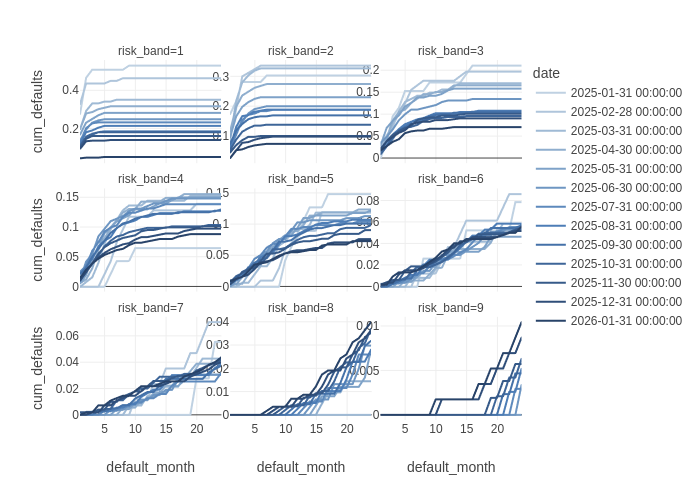

In [27]:
data_chart = data\
.groupby(['date',
          'default_month',
          'risk_band'])\
.agg({'cum_defaults' : 'mean',
      'default_flag' : 'mean'})\
.reset_index()


data_chart = data_chart[data_chart['date'] <= datetime.datetime(2026,1,31)]

fig = px.line(
    data_chart,
    x='default_month',
    y='cum_defaults',
    color='date',
    facet_col = 'risk_band',
    facet_col_wrap = 3,
    template='none',
    width=1000,
    height=1000,
    color_discrete_sequence = colorRampPaletteFromDfColumn(data_chart, 'date', ['#bfd1e2', 
                                                                                '#284369'])
)
fig.update_yaxes(matches=None, showticklabels=True)
Image(fig.to_image("png"))

In [28]:
def withNormalisedPDCurve(df: pd.DataFrame, col_name: str, group_cols: list):
    result = df.copy()
    result[f'{col_name}_12'] = np.where(result['default_month']==12, result[col_name], pd.to_numeric(None))
    result[f'{col_name}_12'] = result.groupby(group_cols)[f'{col_name}_12'].transform('max')
    result[f'{col_name}_norm'] = result[col_name] / result[f'{col_name}_12']
    return result

def withDefaultRatesByGroups(df: pd.DataFrame, group_cols: list):
    result = df\
        .groupby(group_cols)\
        .agg({'id' : 'count',
              'cum_defaults' : 'mean',
              'default_flag' : 'mean'})\
        .reset_index()
    return result
    

data_grouped = data\
.pipe(withDefaultRatesByGroups, ['date', 'risk_band', 'default_month'])\
.pipe(withNormalisedPDCurve, 'cum_defaults', ['date', 'risk_band'])

data_grouped


,date,risk_band,default_month,id,cum_defaults,default_flag,cum_defaults_12,cum_defaults_norm
0,2025-01-31,1,1,47,0.276596,0.276596,0.531915,0.52
1,2025-01-31,1,2,47,0.468085,0.191489,0.531915,0.88
2,2025-01-31,1,3,47,0.510638,0.042553,0.531915,0.96
3,2025-01-31,1,4,47,0.510638,0.000000,0.531915,0.96
4,2025-01-31,1,5,47,0.510638,0.000000,0.531915,0.96
...,...,...,...,...,...,...,...,...
10363,2028-12-31,9,20,49,0.000000,0.000000,0.000000,NaN
10364,2028-12-31,9,21,49,0.000000,0.000000,0.000000,NaN
10365,2028-12-31,9,22,49,0.000000,0.000000,0.000000,NaN
10366,2028-12-31,9,23,49,0.000000,0.000000,0.000000,NaN


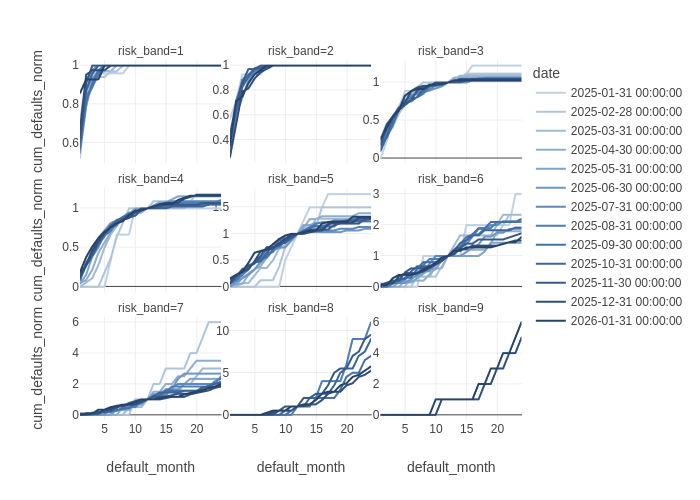

In [32]:
data_chart = data_grouped[data_grouped['date'] <= datetime.datetime(2026,1,31)]

fig = px.line(
    data_chart,
    x='default_month',
    y='cum_defaults_norm',
    color='date',
    facet_col = 'risk_band',
    facet_col_wrap = 3,
    template='none',
    width=800,
    height=800,
    color_discrete_sequence = colorRampPaletteFromDfColumn(data_chart, 'date', ['#bfd1e2', 
                                                                                '#284369'])
)
fig.update_yaxes(matches=None, showticklabels=True)
Image(fig.to_image("png"))